### Relaxed smooth primal

One decide to not take into account the equality constraint at all anymore (only the positive one), and decide to make add an explicit penalisation on the objective function.
Therefore, we introduce :
$$
ROT_{\Phi}(\mathbf{a},\mathbf{b})= \min_{T \geq 0} \langle T,C \rangle + \frac{1}{2}(\Phi(T\mathbf{1}_n, \mathbf{a}) + \Phi(T^{\top}\mathbf{1}_m, \mathbf{b}))
$$ and its semi-relaxed version :
$$
\widetilde{ROT}_{\Phi}(\mathbf{a}, \mathbf{b}) = \min_{\begin{array}{c} T \geq 0;\\ T^{\top}\mathcal{1}_n = b  \end{array}} \langle T,C \rangle + \frac{1}{2}\Phi(T\mathbf{1}_n,a) 
$$
In our case, we will take $\Phi(\mathbf{x}, \mathbf{y}) = \frac{1}{2\gamma}||\mathbf{x} - \mathbf{y}||^2$. Once again, $\gamma$ will be the parameter of our penalisation. Of course, we expect : $\lim\limits_{\gamma \rightarrow 0} T_{\Phi,\gamma}^* = T^*$ and $\lim\limits_{\gamma \rightarrow 0} \tilde{T}_{\Phi,\gamma}^* = T^*$

In [140]:
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy as sc
from scipy.sparse import csr_matrix, identity
from sklearn.metrics.pairwise import euclidean_distances
import cvxpy as cp
import sys

In [141]:
FNAME = 'drapeau.jpg'
img_ref = Image.open(FNAME).convert('RGB')
x = np.array(img_ref)
r_ref, g_ref, b_ref= np.rollaxis(x, axis = -1)
x_ref = np.dstack([r_ref, g_ref, b_ref])
img_ref = Image.fromarray(x_ref, 'RGB')

In [142]:
FNAME = 'arbre.jpg'
img_src = Image.open(FNAME).convert('RGB')
x = np.array(img_src)
r_src, g_src, b_src = np.rollaxis(x, axis = -1)
x_src = np.dstack([r_src, g_src, b_src])
img_src = Image.fromarray(x_src, 'RGB')

In [143]:
width_ref , length_ref,_= np.shape(x_ref)
width_src, length_src,_ = np.shape(x_src)

N_src = width_src*length_src
N_ref = width_ref*length_ref

In [144]:
###
def find(Y, b):
    """
    Returns the index sought for finding the root 

    Args : 
        Y : vector we want to project on the unitary simplex (list n x 1)
    """
    for i in range(1,len(Y)): #We start from the largest element
        if np.sum([Y[j] - Y[i] for j in range(i)]) - b >= 0:
            return i
    return -1

def root(Y, b):
    """
    Returns the root of h, i.e the optimal Lagrange multiplier of the kkt conditions
    """
    Y_p = np.sort(Y) #We sort elements from smaller to larger
    Y_p = np.flip(Y_p)
    i = find(Y_p, b)
    if i >= 0:
        return (np.sum(Y_p[:i]) - b)/i
    else:
        return (np.sum(Y) - b)/len(Y)
    
def max(a,b):
    if a<b: 
        return b
    return a

def proj_simplexe(Y, b): #0< b < 1
    """
    Compute the orthogonal projection on the simplex scaled by b
    Args : 
        Y : vector I want to project (list n)
        b : scalar by which I scale the simplex
    Outputs : 
        Projected vector on b-scaled simplex
    """
    if b > 1 or b < 0:
        return 'error'
    mu = root(Y, b)
    if mu == 'non feasible':
        return Y
    else:
        return [max(Y[i] - mu, 0) for i in range(len(Y))]

In [145]:
colors_ref = np.empty((width_ref*length_ref,3))
j = 0
for i in range(width_ref*length_ref):
    j = i%length_ref #number of column
    l = i//length_ref #number of row
    colors_ref[i,0] = r_ref[l,j]
    colors_ref[i,1] = g_ref[l,j]
    colors_ref[i,2] = b_ref[l,j]

colors_src = np.empty((width_src*length_src,3))
j = 0
for i in range(width_src*length_src):
    j = i%length_src #width
    l = i//length_src
    colors_src[i,0] = r_src[l,j]
    colors_src[i,1] = g_src[l,j]
    colors_src[i,2] = b_src[l,j] 

Text(0.5, 0, 'N° clusters')

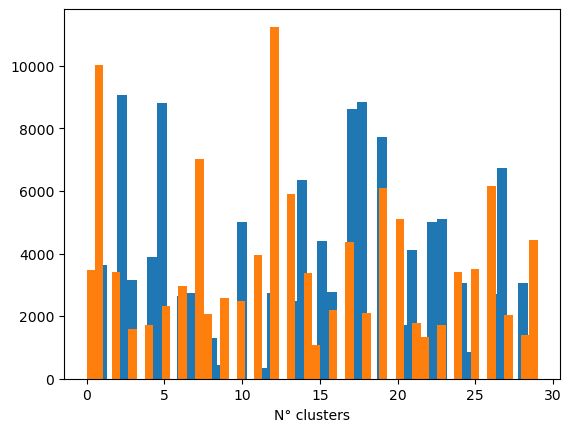

In [146]:
n_src, n_ref = 30, 30 #number of clusters
k_means_color_ref = KMeans(n_clusters = n_ref, random_state = 0, n_init = "auto").fit(colors_ref)
label_ref = k_means_color_ref.labels_
hist_ref = np.histogram(label_ref, bins = n_ref)
plt.hist(label_ref, bins = "auto")

k_means_color_src = KMeans(n_clusters = n_src, random_state = 0, n_init = "auto").fit(colors_src)
label_src = k_means_color_src.labels_
hist_src = np.histogram(label_src, bins = n_src)
plt.hist(label_src, bins = "auto")
plt.xlabel('N° clusters')

In [147]:
X = [i for i in range(10)]
a = [hist_ref[0][i]/N_ref for i in range(n_ref)]
b = [hist_src[0][i]/N_src for i in range(n_src)]

Building of matrix $(C_{i,j})_{i,j \in \llbracket 1,m\rrbracket \times \llbracket 1,n \rrbracket} = (d(\hat{\mathbf{x}}_i^{\text{ref}}, \hat{\mathbf{x}}_j^{\text{src}}))_{i,j \in \llbracket 1,m\rrbracket \times \llbracket 1,n \rrbracket}$ where $\hat{\mathbf{x}}_i^{\text{ref}}$ is the i-th centroid  of the reference image and $\hat{\mathbf{x}}_j^{\text{src}}$ is the j-th centroid of the source image.

In [148]:
cluster_center_ref = k_means_color_ref.cluster_centers_/256 #scaling
cluster_center_src = k_means_color_src.cluster_centers_/256 #scaling

def dist(x,y):
    """
    return euclidian distance between x and y, with a more stable implementation
    Outputs : 
        ||x - y||^2
    """
    return np.dot(x,x) - 2*np.dot(x,y) + np.dot(y,y)

def kullback_l(u,v):
    """
    Kullback Leibler divergence of u and v

    Outputs : 
        KL(u||v)
    """
    if len(u) != len(v) : 
      return 'error, vectors are not the same size'
    div = 0
    for i in range(len(u)):
        if u[i]*v[i] > 0:
            div += u[i]*np.log(u[i]/v[i]) - u[i] + v[i]
        elif u[i] == 0:
            div += v[i]
        else:
            div += np.infty
    return div

c = np.empty((n_ref*n_src))
for i in range(n_ref): #Nombre de lignes
    for j in range(n_src): #Nombre de colonnes
        c[i + j * n_ref] = dist(cluster_center_src[j], cluster_center_ref[i])

norm_c = np.max(c)
nu_1 = np.max(((2 + n_src/n_ref)*np.min((a)), np.min((b))))
nu_2 = np.max(((2 + n_ref/n_src)*np.min((b)), np.min((a))))
L = norm_c**2*np.min((nu_1 + n_src, nu_2 + n_ref))

In [149]:
def mean_vector(T,y,n_src,n_ref):
    """
    new color after transport of y with T
    Args:
        T : transport plan (list nm)
        y : cluster of the source (or reference) image (int)
        n_src : number of cluster of the source image (int)
        n_ref : number of cluster of the reference image (int)
    Outputs : 
        solution of the barycentric problem projection
    """
    x = np.empty((n_ref,3))
    for i in range(n_ref):
        t = 0
        for j in range(n_src):
            t += T[i + j*n_ref]*y[j]
        x[i] = t/np.sum([T[i + j*n_ref] for j in range(n_src)])
    return x

def mean_tensor(T,y,n_src,n_ref):
    """
    new color after transport of y with T
    Args:
        T : transport plan (list n x m)
        y : cluster of the source (or reference) image (int)
        n_src : number of cluster of the source image (int)
        n_ref : number of cluster of the reference image (int)
    Outputs : 
        solution of the barycentric problem projection
    """
    x = np.empty((n_ref,3))
    for i in range(n_ref):
        for j in range(n_src):
            x[i] += T[i,j]*y[j]
        x[i] /= np.sum(T[i,:])
    return x

def from_vector_to_tensor(t,m,n):
    """
    Transform a vector of size mn into a m times n tensor columnwise like it is done for t and c
    Args : 
        t : vector to transform
        m : number of cluster of reference image
        n : number of cluster of source image
    Output : 
    The square matrix equivalent to t in columnwise setting
    """
    T = np.empty((m,n))
    for i in range(m*n):
        j = i//m
        l = i%m
        T[l,j] = t[i]
    return T

def from_vector_to_tensor(t,m,n):
    """
    Transform a vector of size mn into a m times n tensor columnwise like it is done for t and c
    Args : 
        t : vector to transform
        m : number of cluster of reference image
        n : number of cluster of source image
    Output : 
    The square matrix equivalent to t in columnwise setting
    """
    T = np.empty((m,n))
    for i in range(m*n):
        j = i//m
        l = i%m
        T[l,j] = t[i]
    return T

def from_tensor_to_vector(T,m,n):
    """
    Transform a vector of size mn into a m times n tensor columnwise like it is done for t and c
    Args : 
        t : vector to transform
        m : number of cluster of reference image
        n : number of cluster of source image
    Output : 
    The square matrix equivalent to t in columnwise setting
    """
    t = np.empty((n*m))
    for i in range(n*m):
        j = i//m
        l = i%m
        t[i] = T[l,j]
    return t

C = from_vector_to_tensor(c,n_ref,n_src)

In [170]:
def function_relaxed(x):
    """
    fully relaxed function for Phi = ||x - y||^2/(2*gamma)
    Args : 
        x : contains T (list n_ref x n_src)
    Outputs : 
        return the evaluation of the relaxed function evaluated at x
    """
    t_n = np.zeros((n_ref))
    t_m = np.zeros((n_src))
    for i in range(n_ref):
        t_n[i] = np.sum([x[i + j*n_ref] for j in range(n_src)])
    for j in range(n_src):
        t_m[j] = np.sum([x[i + j*n_ref] for i in range(n_ref)])
    return np.dot(x,c) + 1/(2*gamma)*(dist(t_n,a) + dist(t_m,b))

def function_semi_relaxed(x):
    """
    Semi relaxed function for Phi = ||x - y||^2/(2*gamma)
    Args : 
        x : contains T (list n_ref x n_src)
    Outputs : 
        return the evaluation of the relaxed function evaluated at x
    """
    t_n = np.zeros((n_ref))
    t_m = np.zeros((n_src))
    for i in range(n_ref):
        t_n[i] = np.sum([x[i + j*n_ref] for j in range(n_src)])
    for j in range(n_src):
        t_m[j] = np.sum([x[i + j*n_ref] for i in range(n_ref)])
    # print(np.linalg.norm(t.value - x))
    return np.dot(x,c) + 1/(2*gamma)*(dist(t_n,a))

We want to implement FISTA algorithm on the following convex optimization problem : 
$$
\widetilde{ROT}_{\Phi}(\mathbf{a}, \mathbf{b}) = \min_{\begin{array}{c} T \geq 0;\\ T^{\top}\mathcal{1}_n = b  \end{array}} \langle T,C \rangle + \frac{1}{2\gamma}||T\mathbf{1}_n - a||^2 
$$
The FISTA algorithm is an algorithm to solve an optimisation problem of the form : 
$$
\min_x F(x) + G(x)
$$
where F is a proper convex smooth function and G a proper l.s.c convex (possibly non differentiable) function whose proximal operator is well-known. The proximal operator is defined as such : 
$$
\mathcal{P}_G(x) = \argmin_y G(y) + \frac{1}{2}||x - y||^2
$$
The FISTA algorithm consists in the following. 

$$\textit{1. Choose an initial condition}\quad u^{(0)} = v^{(0)} \in \textit{dom}(G) $$
$$\textit{2. at step k,} \\

\quad -\textit{choose a step} \quad \epsilon^{(k)} > 0 \\

\quad -\textit{Update the couple (u,v) by:}\\
    u^{(k+1)} = \mathcal{P}_{\epsilon^{(k)}G}(v^{(k)} - \epsilon^{(k)}\nabla F(v^{(k)})) \\
    v^{(k+1)} = u^{(k+1)} + \frac{k - 1}{k + 2}(u^{(k + 1)} - u^{(k)})
$$
$$
\textit{3. If not convergence, return to step 2 with} \quad k \leftarrow k + 1
$$

In this case, one set $F(T) = \frac{1}{2\gamma}||T\mathbf{1}_n - a||^2$ which is $\frac{1}{\gamma}$-smooth. Therefore, we'll take 
$G(T) = (T,C)$, it satisfies the smoothness hypothesis. Its proximal operator is very simple to compute, it is 
$$
\mathcal{P}_G(X) = \argmin_Y (Y,C) + \frac{1}{2}||X - Y||^2 = X - C
$$

Concerning the step size, it is possible to show that for $\epsilon^{(k)} = \epsilon < \gamma$, convergence is assured. The main trick is to take into account the constraint $T^{\top}\mathcal{1}_n = b, T \geq  0$. For that I have decided to project on this closed convex set at each step k. So a generic step will finally look like : 
$$
u^{(k+1)} = \mathcal{P}_{\epsilon G}(v^{(k)} - \epsilon \nabla F(v^{(k)})) = v^{(k)} - \epsilon\nabla F(v^{(k)}) - \epsilon C\\
v^{(k+1)} = \text{proj}_{b_1\Delta^m\times \cdots \times b_n\Delta^m}(u^{(k+1)} + \frac{k - 1}{k + 2}(u^{(k + 1)} - u^{(k)}))
$$
For the projection, I use the exact same algorithm as before, but the m-simplex are now scaled by the elements of b.
Let's precise the expression of $\nabla F \in \mathbf{R}^{m \times n}$.
Component-wise, we have : 
$(\nabla F^\top)_{i,j} = \frac{1}{\gamma}(\sum_k T_{i,k} - a_i)$, so the value is the same for all column.

Talk about the link between proximal algorithm and sinkhorn iterations

In [204]:
gamma_L = [1e-3,1e-2,1e-1,1e0,1e1] #try for differents gamma
Time = [16, 19, 12, 5, 1.3] #in minutes
gamma = gamma_L[4]
x0 = np.ones((n_src * n_ref))
cons = sc.optimize.LinearConstraint(identity(n_src*n_ref, dtype='int8', format='dia'), lb = 0)
res_relaxed = sc.optimize.minimize(function_relaxed,x0, jac = False, constraints=cons)
t_sol_rel = res_relaxed.x
res_relaxed

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0043802176099695935
       x: [ 3.400e-15  6.469e-15 ... -1.541e-14 -1.784e-14]
     nit: 7
     jac: [ 3.513e-01  1.495e-02 ...  6.794e-02  3.780e-02]
    nfev: 6307
    njev: 7

Pour $\gamma = 10^{-2}$, j'ai $\Delta t = 16m$

Pour $\gamma = 10^{-3}$, j'ai $\Delta t = 14m$

In [172]:
t_n = np.zeros((n_ref))
t_m = np.zeros((n_src))
for i in range(n_ref):
    t_n[i] = np.sum([t_sol_rel[i + j*n_ref] for j in range(n_src)])
for j in range(n_src):
    t_m[j] = np.sum([t_sol_rel[i + j*n_ref] for i in range(n_ref)])

grad = c.copy()

for i in range(n_ref):
    for j in range(n_src):
        grad[i + j*n_ref] += t_n[i] - a[i] + t_m[j] - b[j]

In [205]:
def equality(m,n):
    """
    Build here all the equality constraints for regular OT
    Args : 
        m : number of constraints (i.e number of cluster colors) for reference image (int n_ref)
        n : number of constraints (i.e number of cluster colors) for source image (int n_ref)

    Output:
        Matrix for first set of constraints A1 and second set of constraints
    """
    A = np.zeros((n,n*m)) #equality for b

    k = 0
    for j in range(n):
        A[j,k: k + m] = 1
        k += m
    return A

A1 = equality(n_ref, n_src)
A = np.concatenate((np.eye((n_ref*n_src)), A1))
x0 = np.ones((n_src * n_ref))*0.01 #Starting point is very important
lb = np.concatenate((np.zeros((n_src*n_ref)), b))
ub = np.concatenate((np.ones((n_src*n_ref))*np.infty, b))
cons = sc.optimize.LinearConstraint(A, lb = lb, ub = ub)
res_semi_relaxed = sc.optimize.minimize(function_semi_relaxed,x0, jac = False, constraints=cons)
t_sol_semi_rel = res_semi_relaxed.x
res_semi_relaxed

c:\Users\hugon\anaconda3\Lib\site-packages\scipy\optimize\_constraints.py:537: OptimizeWarning: Equality and inequality constraints are specified in the same element of the constraint list. For efficient use with this method, equality and inequality constraints should be specified in separate elements of the constraint list. 
  warn("Equality and inequality constraints are specified in the same "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.015700664908774125
       x: [ 1.963e-14  3.015e-02 ... -2.415e-14 -3.292e-14]
     nit: 14
     jac: [ 3.615e-01  2.054e-02 ...  8.033e-02  4.261e-02]
    nfev: 12614
    njev: 14

Pour $\gamma = 10^{-2}$, j'ai $\Delta t = 14 min$

FISTA : Donner les vitesses de convergence avec le cours de d'Aspremont et expliquer l'algorithme du gradient proximal avec le cours de large scale optimization

In [154]:
gamma = 1e-2
m = 30
n = 30
def fista(eps,u_init, C, N_max, step):
    """
    Implement FISTA algorithm on the 
    Args:
        step : step size of the proximal method (int)
        u_init : initialization value of the transportation plan (List n_ref x n_src)
        C : cost matrix (array n_ref x n_src)
        N_max : maximum number of iteration (int)
    Outputs : 
        return T at the convergence of the algorithm
    """
    #initialization of the values
    v = u_init 
    u = u_init

    #initialisation of the gradient
    grad_F = np.empty((m*n))
    u_p = 2*u
    delta = u
    V = from_vector_to_tensor(v, m, n)
    #count the # of step
    k = 1

    while k < N_max and np.linalg.norm(delta)/np.linalg.norm(u) > eps:
        for i in range(n): #Compute the gradient at v^(k)
            for j in range(m):
                grad_F[i + j*m] = 1/gamma*(v[i + j*m] - a[i])
        #step 1
        u_p = v - step*(grad_F + c[:m*n]) #u^(k+1)
        delta = u_p - u
        #step 2
        v = u_p + (k - 1)/(k + 2)*delta #v^(k+1)
        u = u_p

        #Column-wise projection on the cartesian product of scaled m-simplex
        V = from_vector_to_tensor(v,m,n)
        for i in range(m):
           for j in range(n):
                V[:,j] = proj_simplexe(V[:,j], b[j]) #projection of v^(k+1) on the simplex
        v = from_tensor_to_vector(V,m,n)
        k += 1

    if k == N_max:
        print("maximum number of iteration reached")
    return v,k

In [155]:
N_max = 1e5
eps = 1e-9
x0 = np.ones((m*n))*eps
step = gamma*0.9
t_fista,k = fista(eps, x0, C, N_max, step)

In [156]:
T_semi_rel = from_vector_to_tensor(t_sol_semi_rel,m,n)

In [157]:
cluster_center_new_rel = mean_vector(t_sol_rel,cluster_center_src,n_src,n_ref)
cluster_center_new_semi_rel = mean_vector(t_sol_semi_rel,cluster_center_src,n_src,n_ref)
cluster_center_new_semi_rel_fista = mean_vector(t_fista,cluster_center_src,n_src,n_ref)

In [158]:
image_n = cluster_center_new_rel[label_ref]
image_new = np.zeros((width_ref, length_ref, 3))
for i in range(width_ref):
    for j in range(length_ref):
        image_new[i,j] = image_n[i*length_ref + j] #row-wise

image_n_semi = cluster_center_new_semi_rel[label_ref]
image_new_semi = np.zeros((width_ref, length_ref, 3))
for i in range(width_ref):
    for j in range(length_ref):
        image_new_semi[i,j] = image_n_semi[i*length_ref + j] #row-wise

image_n_semi_fista = cluster_center_new_semi_rel_fista[label_ref]
image_new_semi_fista = np.zeros((width_ref, length_ref, 3))
for i in range(width_ref):
    for j in range(length_ref):
        image_new_semi_fista[i,j] = image_n_semi_fista[i*length_ref + j] #row-wise

(-0.5, 399.5, 299.5, -0.5)

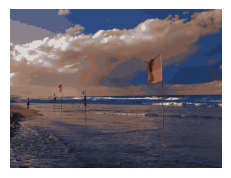

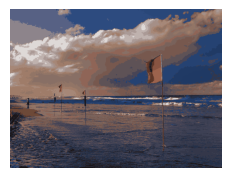

In [159]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(221)
ax.imshow(image_new)
ax.axis("off")

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(222)
ax.imshow(image_new_semi)
ax.axis("off")

# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(223)
# ax.imshow(image_new_semi_fista)
# ax.axis("off")

In [160]:
T_sol_semi_rel = from_vector_to_tensor(t_sol_semi_rel, n_src, n_ref)
sparsity = (n_ref*n_src - len(t_sol_semi_rel[t_sol_semi_rel > 0]))/(n_ref*n_src) #Percentage of sparsity
sparsity

0.24444444444444444

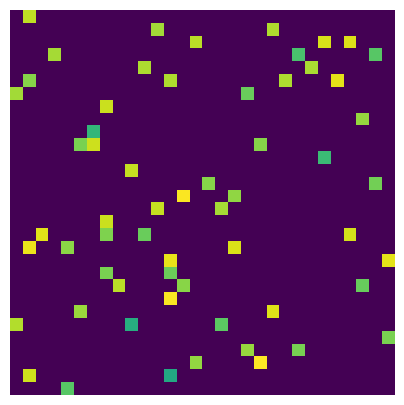

In [161]:
plt.figure(figsize=(5,5))
plt.imshow(np.log(T_sol_semi_rel+1e-5))
plt.axis('off');

In [162]:
T_sol_rel = from_vector_to_tensor(t_sol_rel, n_ref, n_src)
sparsity = (n_ref*n_src - len(t_sol_rel[t_sol_rel > 0]))/(n_ref*n_src) #Percentage of sparsity
sparsity

0.7133333333333334

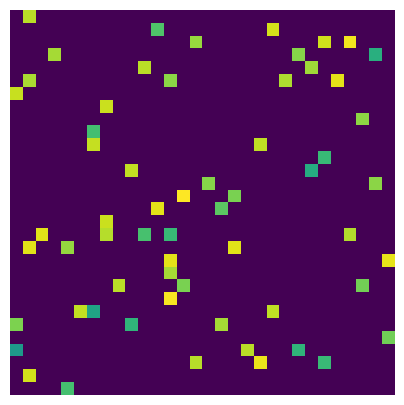

In [163]:
plt.figure(figsize=(5,5))
plt.imshow(np.log(T_sol_rel+1e-5))
plt.axis('off');

In [164]:
T_sol_semi_rel_fista = from_vector_to_tensor(t_sol_semi_rel_fista, n_ref, n_src)
sparsity = (n_ref*n_src - len(t_sol_semi_rel_fista[t_sol_semi_rel_fista > 0]))/(n_ref*n_src) #Percentage of sparsity
sparsity

NameError: name 't_sol_semi_rel_fista' is not defined

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(np.log(T_sol_semi_rel_fista+1e-5))
plt.axis('off');

Solving regular OT to have $T^\star$ to compare with dual solutions.

In [206]:
def equality_T(m,n):
    """
    Build here all the equality constraints for regular OT
    Args : 
        m : number of constraints (i.e number of cluster colors) for reference image (int n_ref)
        n : number of constraints (i.e number of cluster colors) for source image (int n_ref)

    Output:
        Matrix for first set of constraints A1 and second set of constraints
    """
    A1 = np.zeros((m,n*m)) #equality for a
    A2 = np.zeros((n,n*m)) #equality for b

    for j in range(m):
        for i in range(0,n*m,m):
            A1[j, j + i] = 1
    k = 0
    for j in range(n):
        A2[j,k: k + m] = 1
        k += m
    return A1,A2

d = np.concatenate((a,b))
t = cp.Variable(n_ref*n_src)
A1,A2 = equality_T(n_ref,n_src)
A = np.concatenate((A1,A2))

In [207]:
prob = cp.Problem(cp.Minimize(c.T@t),
                 [A @ t == d, t >= 0])
prob.solve(solver = 'ECOS')
# Print result.
print("\n The optimal value is", prob.value)
print("A solution t is")
print(t.value)


 The optimal value is 0.04999546769403864
A solution t is
[-2.53330202e-14  4.02655533e-13  3.54507494e-14  4.74552631e-13
  6.67824884e-14 -1.04415403e-14  2.19833333e-02 -7.75706318e-15
 -3.79946978e-14  4.71353471e-14  1.12029979e-13 -1.45204104e-14
  1.56961846e-13  6.15555872e-14 -2.61026993e-14  8.72521132e-13
  1.03478724e-14  1.64715394e-14 -1.91073657e-14  1.62114412e-15
 -1.67949897e-14 -3.18650287e-14 -8.91289519e-15  1.97786176e-13
  7.53521754e-03 -1.02759493e-14  1.69257045e-03  6.32975082e-14
 -1.89074242e-14 -2.89120259e-14  1.87583333e-02  7.25825994e-15
  2.57217679e-13 -3.67038882e-14  5.78988599e-14  1.59304899e-02
 -2.59512119e-14  2.06429318e-13  8.57646894e-14 -3.24987471e-14
  5.93279330e-14 -1.42663908e-14  1.33576365e-14 -4.13407485e-14
  1.83466666e-12 -8.41296724e-15  1.14491218e-13  7.27132633e-13
  3.03655344e-02  1.37205721e-12  6.11284204e-13  5.52673805e-13
  1.52882665e-12  2.69539147e-14 -1.88062617e-14  8.30776175e-14
 -3.19677878e-14  1.27286880e-1

Plof of $||T_{rel} - T^\star||$

In [ ]:
file_path = 'rel.txt'

with open(file_path) as file:
    line_list = file.readlines()
    line_list = [float(item.rstrip()) for item in line_list]

In [ ]:
file_path = 'semi_rel.txt'

with open(file_path) as file:
    line_list_s = file.readlines()
    line_list_s = [float(item.rstrip()) for item in line_list_s]

Text(0, 0.5, 'Error to optimal transport T*')

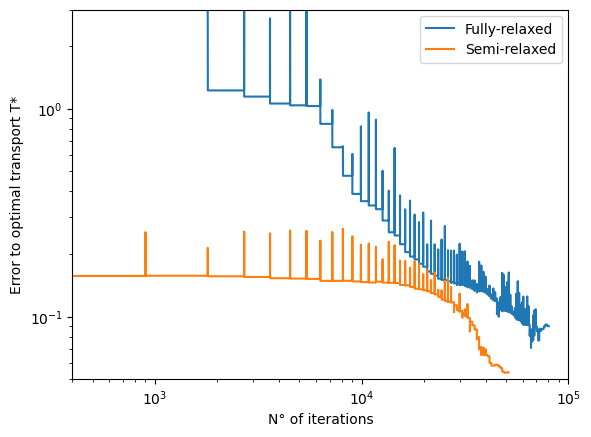

In [ ]:
n_iter_semi = len(line_list_s)
n_iter = len(line_list)
N = np.linspace(1,n_iter,n_iter)
plt.loglog(N,line_list, label = 'Fully-relaxed')
N_semi = np.linspace(1,n_iter_semi,n_iter_semi)
plt.loglog(N_semi,line_list_s, label = 'Semi-relaxed')
plt.legend()
plt.ylim(5e-2,3e0)
plt.xlim(4e2,1e5)
plt.xlabel('N° of iterations')
plt.ylabel('Error to optimal transport T*')

In [185]:
def equality_T(m,n):
    """
    Build here all the equality constraints for regular OT
    Args : 
        m : number of constraints (i.e number of cluster colors) for reference image (int n_ref)
        n : number of constraints (i.e number of cluster colors) for source image (int n_ref)

    Output:
        Matrix for first set of constraints A1 and second set of constraints
    """
    A1 = np.zeros((m,n*m)) #equality for a
    A2 = np.zeros((n,n*m)) #equality for b

    for j in range(m):
        for i in range(0,n*m,m):
            A1[j, j + i] = 1
    k = 0
    for j in range(n):
        A2[j,k: k + m] = 1
        k += m
    return A1,A2

d = np.concatenate((a,b))
t = cp.Variable(n_ref*n_src)
A1,A2 = equality_T(n_ref,n_src)
A = np.concatenate((A1,A2))

In [208]:
print(np.linalg.norm(np.dot(A,t_sol_rel) - d)/np.linalg.norm(d)) #erreur relative vis-à-vis de la contrainte d'égalité
print(np.linalg.norm(t_sol_rel - t.value))

0.8572993633500924
0.16148141174606603


In [209]:
print(np.linalg.norm(np.dot(A,t_sol_semi_rel) - d)/np.linalg.norm(d)) #erreur relative vis-à-vis de la contrainte d'égalité
print(np.linalg.norm(t_sol_semi_rel - t.value))

0.703905506632895
0.24399341646917316


In [218]:
norm_c = np.max(c)
nu_1 = np.max(((2 + n_src/n_ref)*np.min((a))**(-1), np.min(b)**(-1)))
nu_2 = np.max(((2 + n_ref/n_src)*np.min((b)), np.min((a))))
L = norm_c**2*np.min((nu_1 + n_src, nu_2 + n_ref))
L_tilde = 2*norm_c**2*np.min(a)**-2

Cons_error_rel = [0.003052861815977608, 0.02784927215176215, 0.12338110482657678, 0.33336070753772035, 0.8572993633500924]
transport_error_rel = [0.036862716762810825, 0.09191212596832725, 0.16840913624904247, 0.1862851503597055, 0.16148141174606603]
error_value_rel = [0.04954276405877374, 0.045708766471757825, 0.031984685243931145, 0.015554585213378267, 0.0043802176099695935]
error_value_rel = prob.value - error_value_rel

Cons_error_semi = [0.002264367623849614, 0.021669543497603513, 0.12273665444694115, 0.28438659846103076, 0.703905506632895]
transport_error_semi = [0.016874480674251048, 0.05330168629972323, 0.16193415557958882, 0.20297268054820955, 0.24399341646917316]
error_value_semi = [0.04975517413480063, 0.04769092168394507, 0.03644965064601683, 0.022211077192359353, 0.015700664908774125]
error_value_semi = prob.value - error_value_rel

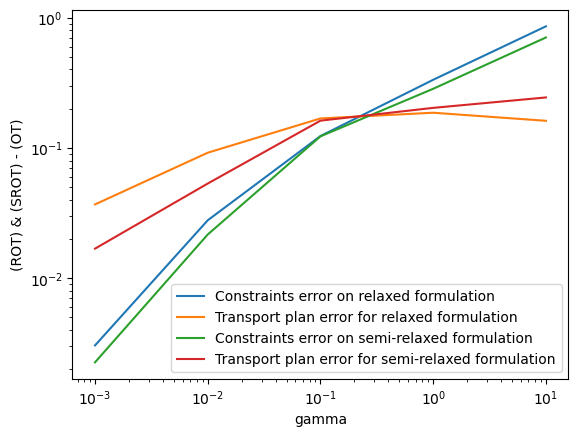

In [224]:
plt.loglog(gamma_L,Cons_error_rel, label = 'Constraints error on relaxed formulation')
plt.loglog(gamma_L,transport_error_rel, label = 'Transport plan error for relaxed formulation')

plt.loglog(gamma_L,Cons_error_semi, label = 'Constraints error on semi-relaxed formulation')
plt.loglog(gamma_L,transport_error_semi, label = 'Transport plan error for semi-relaxed formulation')

plt.xlabel('gamma')
plt.ylabel('(ROT) & (SROT) - (OT)')
plt.legend()

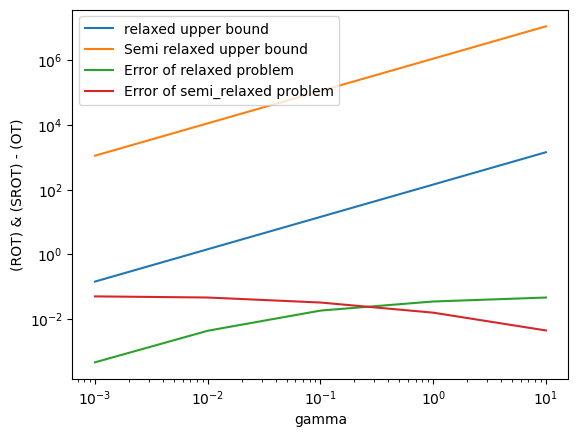

In [222]:
plt.loglog(gamma_L,np.dot(L,gamma_L), label = 'relaxed upper bound')
plt.loglog(gamma_L,np.dot(gamma_L,L_tilde), label = 'Semi relaxed upper bound')
plt.loglog(gamma_L,error_value_rel, label = 'Error of relaxed problem')
plt.loglog(gamma_L,error_value_semi, label = 'Error of semi_relaxed problem')
plt.xlabel('gamma')
plt.ylabel('(ROT) & (SROT) - (OT)')
plt.legend()